In [13]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. SETUP & CONFIG BETÖLTÉSE ---
current_dir = os.getcwd()
if os.path.isdir(os.path.join(current_dir, 'src')):
    src_path = os.path.abspath(os.path.join(current_dir, 'src'))
elif os.path.basename(current_dir) == 'src':
    src_path = current_dir
else:
    src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))

if src_path not in sys.path:
    sys.path.insert(0, src_path)

try:
    import config
    print(f"Config betöltve. Label fájl: {config.LABEL_FILE}")
except ImportError:
    print("HIBA: Nem található a config.py!")

# --- 2. ADATOK BEOLVASÁSA ÉS FELDOLGOZÁSA ---
def prepare_stats():
    if not os.path.exists(config.LABEL_FILE):
        print("HIBA: Nem létezik a ground_truth_labels.csv!")
        return pd.DataFrame()

    df_labels = pd.read_csv(config.LABEL_FILE)
    df_labels = df_labels.dropna(subset=['clean_csv_filename'])

    stats = []
    print("Adatok elemzése és gyertyák számolása...")

    csv_cache = {}

    for _, row in df_labels.iterrows():
        filename = row['clean_csv_filename']
        label_name = row['label']

        start_ts = pd.to_datetime(row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts'])
        end_ts = pd.to_datetime(row['flag_end_ts'])
        duration_mins = (end_ts - start_ts).total_seconds() / 60.0

        # Gyertyahossz számítás
        csv_path = os.path.join(config.DATA_ROOT, filename)
        candle_count = 0

        if filename not in csv_cache:
            if os.path.exists(csv_path):
                try:
                    df_price = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                    csv_cache[filename] = df_price
                except:
                    csv_cache[filename] = None
            else:
                csv_cache[filename] = None

        df_price = csv_cache[filename]

        if df_price is not None:
            mask = (df_price.index >= start_ts) & (df_price.index <= end_ts)
            candle_count = mask.sum()
        else:
            candle_count = 0

        stats.append({
            'File': filename,
            'Label': label_name,
            'Candle_Count': candle_count,
            'Duration_Min': duration_mins
        })

    return pd.DataFrame(stats)

df_stats = prepare_stats()
print(f"Összes annotáció (Label): {len(df_stats)}")

Config betöltve. Label fájl: /home/bence/PycharmProjects/Melytanulas/data/ground_truth_labels.csv
Adatok elemzése és gyertyák számolása...
Összes annotáció (Label): 552


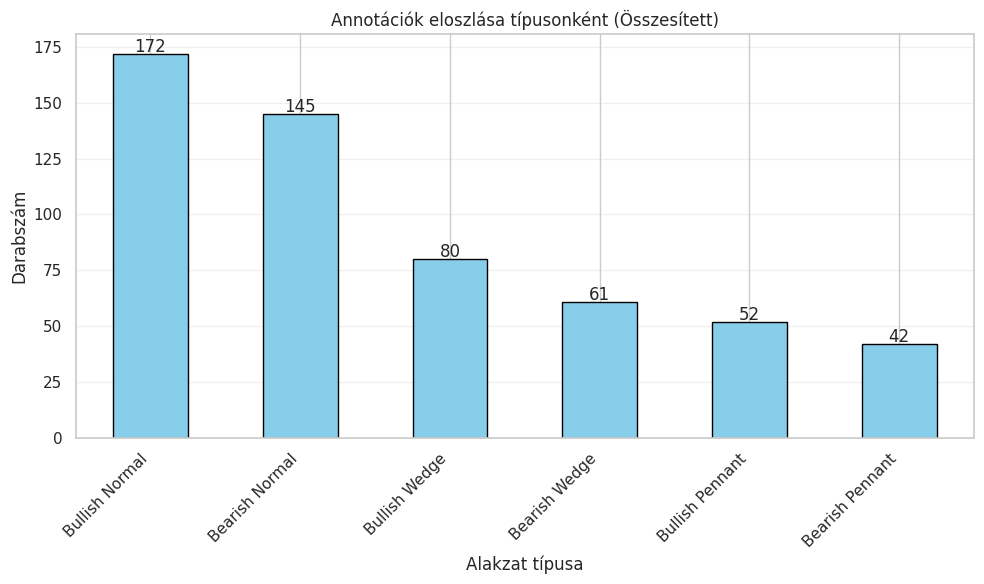

In [14]:

# --- 3. PLOT 1: ANNOTÁCIÓK ELOSZLÁSA ---
if not df_stats.empty:
    plt.figure(figsize=(10, 6))
    ax = df_stats['Label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Annotációk eloszlása típusonként (Összesített)")
    plt.xlabel("Alakzat típusa")
    plt.ylabel("Darabszám")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    plt.tight_layout()
    plt.show()

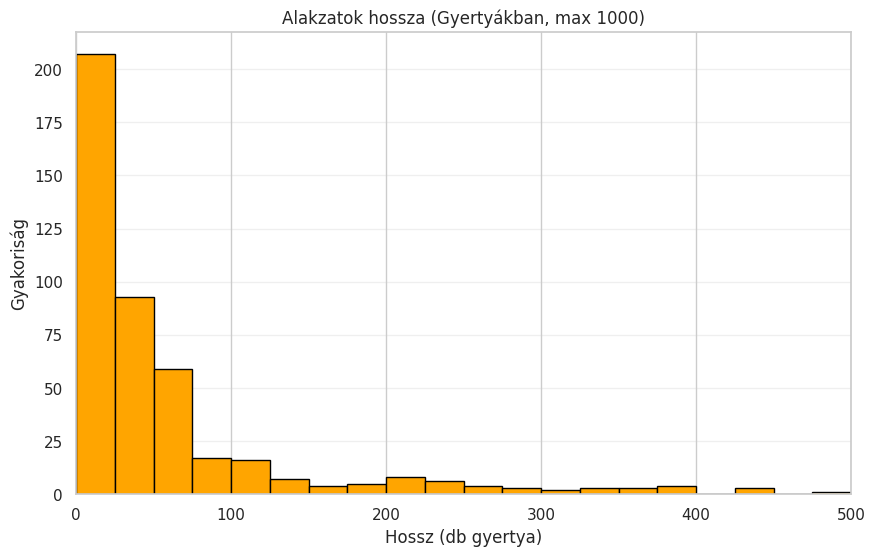

Átlagos hossz: 1021.5090579710145
Min: 2
Max: 47531


In [15]:

# --- 4. PLOT 2: ALAKZATOK HOSSZA (LIMITÁLVA 1000-RE) ---
if not df_stats.empty:
    plt.figure(figsize=(10, 6))

    valid_lengths = df_stats[df_stats['Candle_Count'] > 0]['Candle_Count']

    # range=(0, 1000): Csak ebben a tartományban számolja a hisztogramot
    # bins=40: Finomabb felbontás
    plt.hist(valid_lengths, bins=40, range=(0, 1000), color='orange', edgecolor='black')

    plt.title("Alakzatok hossza (Gyertyákban, max 1000)")
    plt.xlabel("Hossz (db gyertya)")
    plt.ylabel("Gyakoriság")
    plt.grid(axis='y', alpha=0.3)

    # --- X TENGELY LIMITÁLÁSA ---
    plt.xlim(0, 500)

    plt.show()

    print("Átlagos hossz:", valid_lengths.mean())
    print("Min:", valid_lengths.min())
    print("Max:", valid_lengths.max())

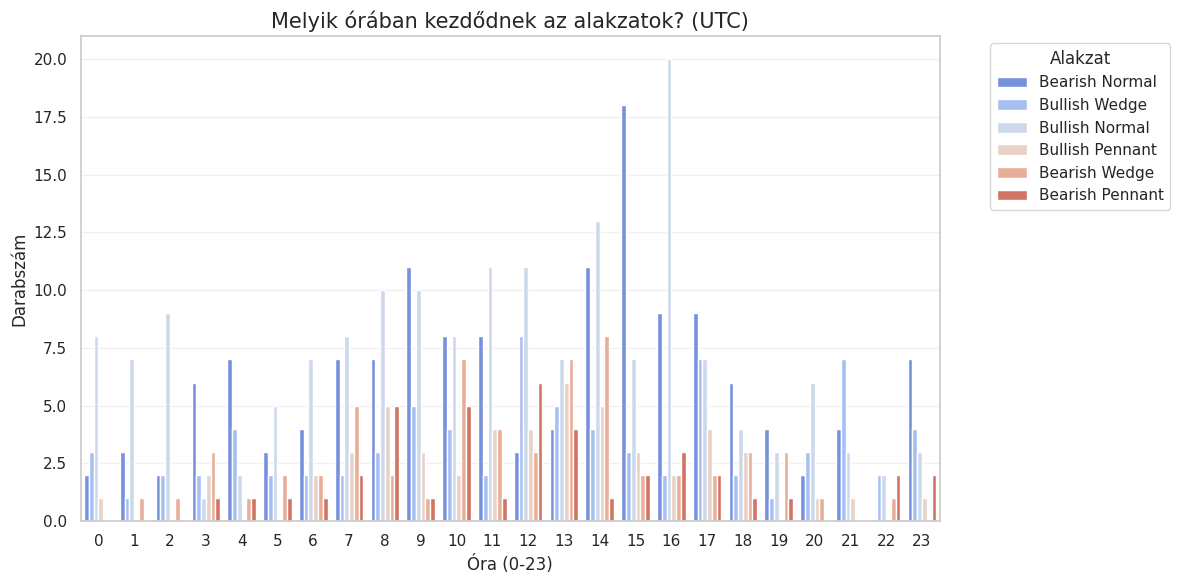

In [16]:
# ==========================================
# 1. MIKOR TÖRTÉNNEK? (Napszak szerinti eloszlás)
# ==========================================
# Kinyerjük az órát a timestampből
df_stats['Start_Time'] = pd.to_datetime([
    row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts']
    for _, row in df_labels.iterrows()
])
df_stats['Hour'] = df_stats['Start_Time'].dt.hour

plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=df_stats, palette='coolwarm', hue='Label')
plt.title("Melyik órában kezdődnek az alakzatok? (UTC)", fontsize=15)
plt.xlabel("Óra (0-23)")
plt.ylabel("Darabszám")
plt.legend(title='Alakzat', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Árváltozások számítása...


/tmp/ipykernel_46994/753522395.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='Price_Change_Pct', data=df_stats, palette='Set2')


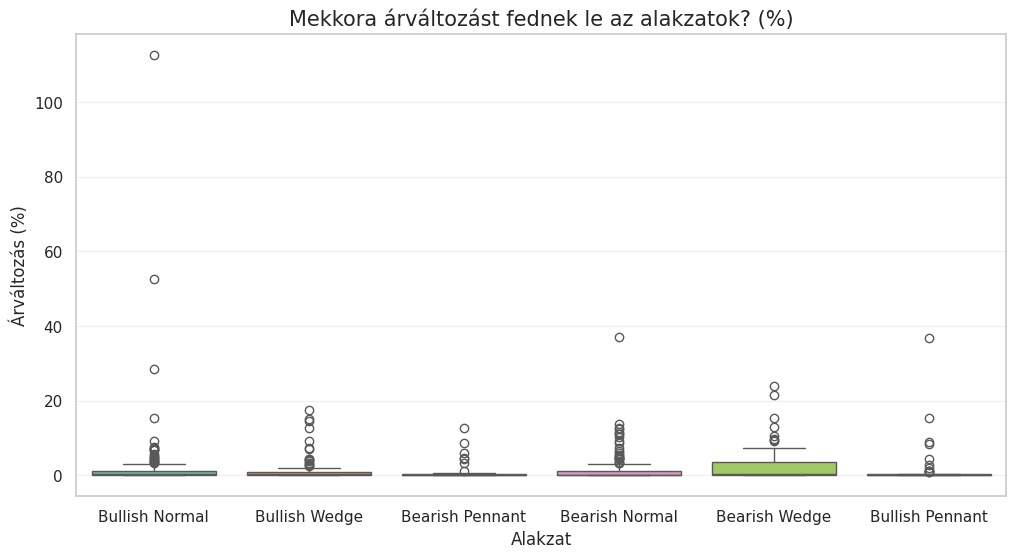

Átlagos árváltozás (%):
Label
Bearish Normal     1.737780
Bearish Pennant    1.112735
Bearish Wedge      2.796495
Bullish Normal     2.164137
Bullish Pennant    1.705358
Bullish Wedge      1.656361
Name: Price_Change_Pct, dtype: float64


In [17]:
# ==========================================
# 2. ÁRVÁLTOZÁS MÉRTÉKE (Volatility Analysis)
# ==========================================
# Kiszámoljuk, mekkora volt a mozgás %-ban az alakzat alatt
price_changes = []
assets = []

print("Árváltozások számítása...")
# Újra végigmegyünk (vagy használhatnánk a cache-t, ha a notebook egyben fut)
csv_cache = {}

for _, row in df_labels.iterrows():
    filename = row['clean_csv_filename']

    # Eszköz nevének kinyerése (pl. EURUSD_1H... -> EURUSD)
    asset_name = filename.split('_')[1] if len(filename.split('_')) > 1 else "Unknown"
    assets.append(asset_name)

    # Cache betöltés logic (rövidítve)
    csv_path = os.path.join(config.DATA_ROOT, filename)
    if filename not in csv_cache:
        if os.path.exists(csv_path):
            try: csv_cache[filename] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
            except: csv_cache[filename] = None
        else: csv_cache[filename] = None

    df_price = csv_cache[filename]
    pct_change = 0.0

    if df_price is not None:
        start_ts = pd.to_datetime(row['pole_start_ts'] if pd.notna(row.get('pole_start_ts')) else row['flag_start_ts'])
        end_ts = pd.to_datetime(row['flag_end_ts'])

        # Árfolyamok lekérése (közelítőleg, ha nincs pont olyan timestamp)
        try:
            # nearest keresés
            start_idx = df_price.index.get_indexer([start_ts], method='nearest')[0]
            end_idx = df_price.index.get_indexer([end_ts], method='nearest')[0]

            price_start = df_price.iloc[start_idx]['close']
            price_end = df_price.iloc[end_idx]['close']

            # Abszolút százalékos változás
            pct_change = abs((price_end - price_start) / price_start) * 100
        except:
            pct_change = 0.0

    price_changes.append(pct_change)

df_stats['Price_Change_Pct'] = price_changes
df_stats['Asset'] = assets

# PLOT: Árváltozás Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Price_Change_Pct', data=df_stats, palette='Set2')
plt.title("Mekkora árváltozást fednek le az alakzatok? (%)", fontsize=15)
plt.ylabel("Árváltozás (%)")
plt.xlabel("Alakzat")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Átlagos árváltozás (%):")
print(df_stats.groupby('Label')['Price_Change_Pct'].mean())


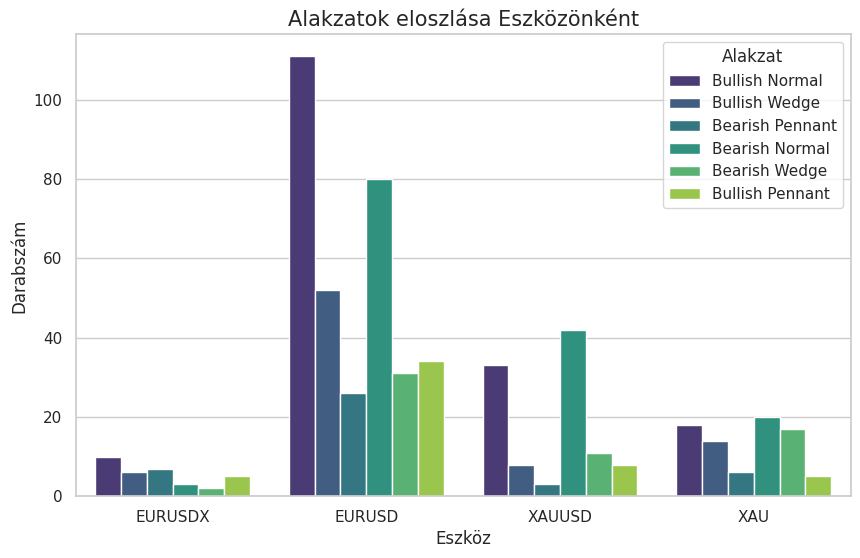

In [18]:
# ==========================================
# 3. ESZKÖZÖK ÖSSZEHASONLÍTÁSA (EURUSD vs XAU)
# ==========================================

if len(df_stats['Asset'].unique()) > 1:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Asset', hue='Label', data=df_stats, palette='viridis')
    plt.title("Alakzatok eloszlása Eszközönként", fontsize=15)
    plt.xlabel("Eszköz")
    plt.ylabel("Darabszám")
    plt.legend(title='Alakzat')
    plt.show()